In [1]:
r"""
This tutorial teaches reading the Hamiltonian from TB2J results, 
manipulating it and making its visualization with MagnoFallas.tools methods
The second goal is to explore detailed properties of magnons:
calculation of the magnon dispersion along a high-symmetry path
and making the 2D maps of group velocities
We use the spin Hamiltonian calculated for a 
layered antiferromagnet CrPS4 as an example
"""

import numpy as np
import matplotlib.pyplot as plt

import MagnoFallas as mfal

In [2]:
## the following line shoud contain a valid path to the tutorial data
TutorialData = '..//TutorialData'

file1 = TutorialData + '//CrPS4//exchange.out'
spins1 = [1.5,1.5,1.5,1.5,  -1.5,-1.5,-1.5,-1.5]
### Initial file contains TB2J-provided Spin Hamiltonian of CrPS4 with a orthorombic unit cell, containing 8 magnetic Cr atoms
### 4 in the bottom layyer (1-st sublattice, spin +3/2) and 4 in the top layer (1-st sublattice, spin -3/2)
### while impopting TB2J files spins should be defined by user


H1 = mfal.ReadTB2J(file1, spins1)

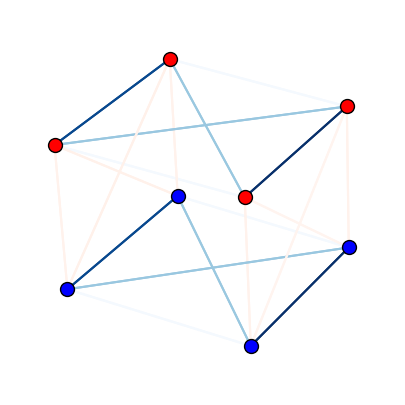

[[10.89506339  0.          0.        ]
 [ 0.          7.28913343  0.        ]
 [-0.43520364  0.         12.25222348]]


In [3]:
### Here we take a look at the Hamiltonian and print it's unit cell
mfal.tools.drawHam(H1, dim=3, file='Hamiltonian1.png')

print(H1.cell)

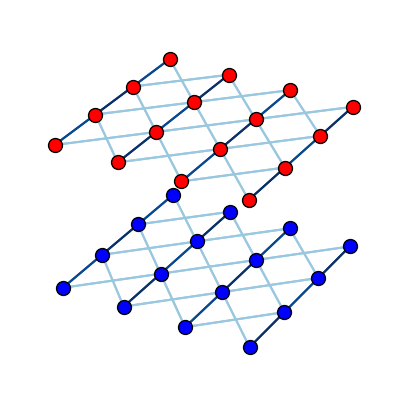

In [4]:
### tools.drawHam is tailored to show only a single unit cell of a Hamiltonian. Sometimes this is not enough to understand it, 
### because the inter-cell exchange interactions are not shown. In this case it might be reasonable to first construct a super-cell
### and only than do the visualization

H1sc = mfal.tools.project(H1, 2*H1.a1, 2*H1.a2, H1.a3, dim=3)
mfal.tools.drawHam(H1sc, dim=3, minJ=1, file='Hamiltonian2.png')

#Here H1.a1, H1.a2, H1.a3 - lattice vectors of the initial spin Hamiltonian
## the function mfal.tools.project(H, a1, a2, a3) project the spin Hamiltonian to the new lattice vectors a1, a2, a3
## This is the user's responsibility to ensure that the new vectors are compatible with lattice strucure (vectors of a super-cell 
## are always compatible)

## parameter minJ enforsces the code to show only the exchange interactions larger than the specified value
## please run help()  (e.g. help(mfal.tools.project) ) to see additional parameters of all the functions

In [5]:
### The orthorombic cell of CrPS4 is not the primitive cell. Therefore, the bands calculated from H1 would be folded. 
## To avoid this we project the Hamiltonian on the promitive cell

## the lattice vectors of the primitive cell should be provided by user
na1 = (H1.a1 + H1.a2)/2
na2 = (H1.a1 - H1.a2)/2
na3 = H1.a3

H2 = mfal.tools.project(H1, na1,na2, na3, dim=3)

In [6]:
##  Next we are going to show magnon dispersion along the high-symmetry K-path
##  It is usually derived from the reciprocal vectors of the lattice
##  this vectors are stored in H2.b1, H2.b2 and H2.b3 parameters of the Hamiltonian
##  User should manually set the key points of the high-symmetry path

pG = np.zeros(3)
pM = -0.5*H2.b1 - 0.5*H2.b2
pK = -0.63813*H2.b1 - 0.36187*H2.b2
pM1 = -0.5*H2.b1
pK1 = -0.36187*H2.b1 +0.36187*H2.b2
Points = [pG, pM, pK, pM1, pK1, pG]

## labels correspond to the key points and will be used for plotting
labels = [r'$\Gamma$', r'${\rm M}$', r'${\rm K}$', r'${\rm M^\prime}$', r'${\rm K^\prime}$', r'$\Gamma$']

kpoi, xx, Xmarks = mfal.Kpath(Points)
## The function mfal.Kpath() returns 3 values: the set of k-points in the path kpoi;
## xx - a useful x-coordinates for the plots; Xmarks - values of x, corresponding to the key points

In [7]:
## Here we calculate the magnon dispersion without numba-optimization
Magn = mfal.MagnonDispersion(H2)
oms1 = np.array([Magn.omega(k) for k in kpoi])


## There is a second, numba-compatible option. It is significantly faster when the diagonalization
## of the spin Hamiltonian should be made many times. Nevertheless, the initial JIT-compilation 
## might be not effective for the short taskes
NBH2 = mfal.NBhamiltonian(H2)
oms2 = np.array([mfal.NBomega(NBH2, k) for k in kpoi])

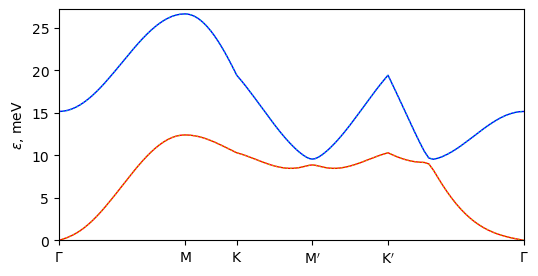

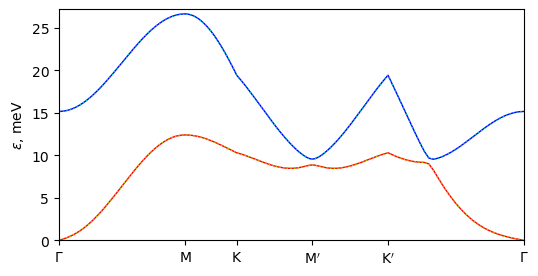

In [8]:
### Here we plot the results
fig = plt.figure(figsize=(6,3.0))

plt.plot(xx, oms1[...,0], 'b-', linewidth=1.0 )
plt.plot(xx, oms1[...,1], 'c:', linewidth=1.0 )
plt.plot(xx, oms1[...,2], 'r-', linewidth=1.0 )
plt.plot(xx, oms1[...,3], 'y:', linewidth=1.0 )
plt.xlim(0, np.max(xx))
plt.ylabel(r'$\varepsilon$, meV')
plt.xticks(Xmarks, labels)
plt.savefig('CrPS4-dispersion-v1.png', bbox_inches='tight')
plt.ylim(0,1.02*np.max(oms1))
plt.show()

### The results from both methods are the same
fig = plt.figure(figsize=(6,3.0))

plt.plot(xx, oms2[...,0], 'b-', linewidth=1.0 )
plt.plot(xx, oms2[...,1], 'c:', linewidth=1.0 )
plt.plot(xx, oms2[...,2], 'r-', linewidth=1.0 )
plt.plot(xx, oms2[...,3], 'y:', linewidth=1.0 )
plt.xlim(0, np.max(xx))
plt.ylabel(r'$\varepsilon$, meV')
plt.xticks(Xmarks, labels)
plt.savefig('CrPS4-dispersion-v2.png', bbox_inches='tight')
plt.ylim(0,1.02*np.max(oms1))
plt.show()

#### Note that the material is antiferromagnetic with 4 atoms in a magnetic unit cell. It yields two pairs of degenerate bands

### Also note that CrPS4 is a van der Waaltz material. Therefore, although the Hamiltonian is 3D, we treat it as 2D for magnon dispersions.

In [9]:
## The next goal of the present tutorial is to calculate the "maps" of group velocities 
## of acoustic magnons in the first Brillouin zone

### we start from defining two functions that calculate th x- and y-components of the
### group velocities at arbitrary wavevector k. The functions should take only k as the argument

band = 3
## note that magnon mands are counted started from the highest energy. Therefore optical
## magnons correspond to the bands 0 and 1; and acoustical - to the bands 2 and 3

def vx(k):
    Vvec = mfal.groupV_NB(NBH2, k, band)
    return Vvec[0]

def vy(k):
    Vvec = mfal.groupV_NB(NBH2, k, band)
    return Vvec[1]
## we use a numba-compatible function mfal.groupV_NB;
## it results in a vector of group velocity. Accordingly, we select its [0] and [1] 
## components for x and y

In [10]:
## now we calculate the maps themselves (for now as arrays).
## for this end we use the function tools.BrilMap
## we give it function (vx or vy),  ¡¡¡non-Numba!!!! spin Hamiltonian (even when we use numba-accelerated functions as in this case)
## Np - is the number of points per axis (larger number results in a more beutiful
##  picture but can make the calculations slow)
resVx, akx1, aky1 = mfal.tools.BrilMap(vx, H2, Np=200)
resVy, akx2, aky2 = mfal.tools.BrilMap(vy, H2, Np=200)
## the result of the tools.BrilMap is the map itself (as an array) and x- and y- coordinates
## useful for plotting

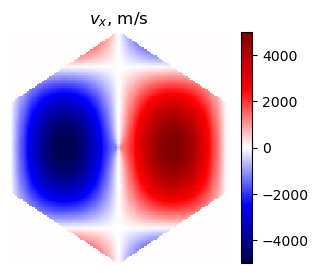

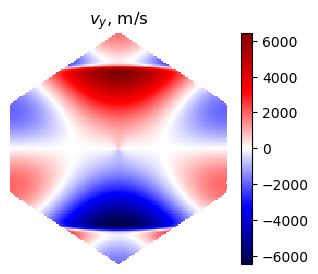

In [11]:
## Here we plot the resulting maps with tools.DrawMapSym() function 
plt.figure(figsize=(3.5,3))
mfal.tools.DrawMapSym(akx1, aky1, resVx)
plt.colorbar()
plt.axis('off') 
plt.title(r'$v_x$, m/s')
plt.savefig('mapVx.png', bbox_inches='tight')
plt.show()

plt.figure(figsize=(3.5,3))
mfal.tools.DrawMapSym(akx1, aky1, resVy)
plt.colorbar()
plt.axis('off') 
plt.title(r'$v_y$, m/s')
plt.savefig('mapVy.png', bbox_inches='tight')
plt.show()
